In [13]:
import numpy
import typing
import logging
import cv2
from functools import cache
import gco
from gco import pygco
import matplotlib.image
import matplotlib.pyplot
from utils import get_logger, INTEGER_MAX_VALUE


In [14]:
def compute_distance_normalize(point1: numpy.ndarray, point2: numpy.ndarray) -> float:
    """
    compute distance of two pixels
    Parameters
    ----------
    point1: ndarray, uint8, shape=(3)
        point one
    point2: ndarray, uint8, shape=(3)
        point two
    """
    # return (abs(point1[0]-point2[0]) + abs(point1[1] - point2[1]) + abs(point1[2] - point2[2]) ) / 3 / 255
    # if not dividing 255 as the C pseudocode example, there will be a overflowing of MAX_VALUE of Integer when calling pycgo.cut_grid_graph
    # return numpy.sum(numpy.abs(point1-point2)) / (3 * 255)
    return numpy.sum(numpy.abs(point1-point2)) / (765)

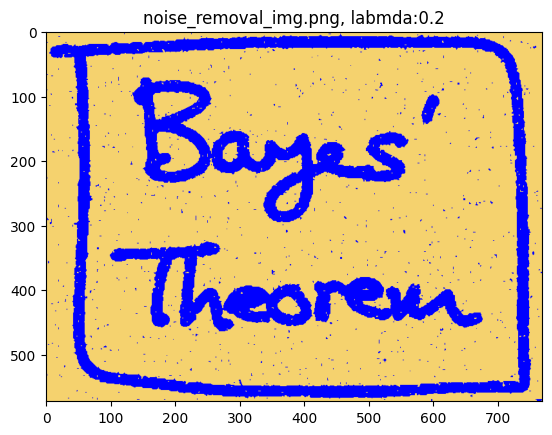

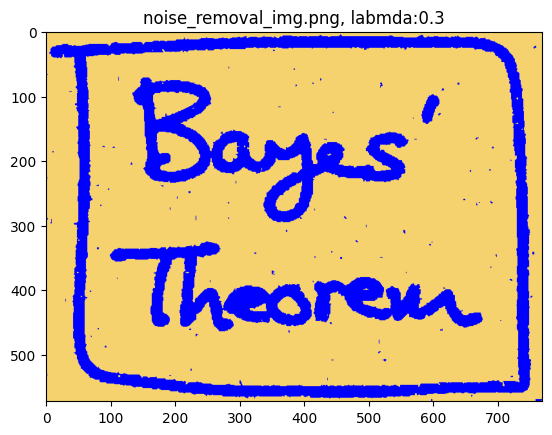

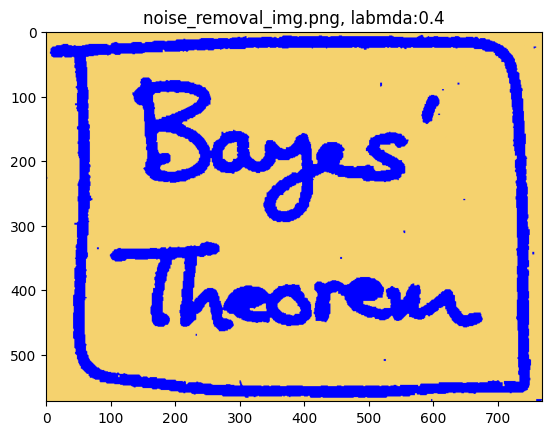

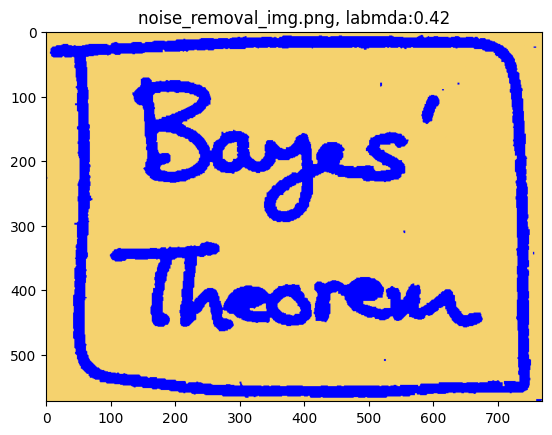

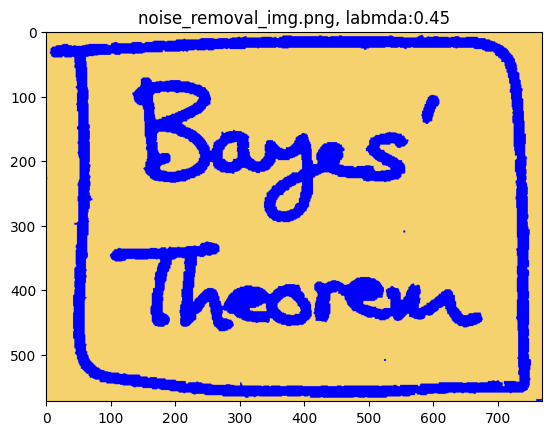

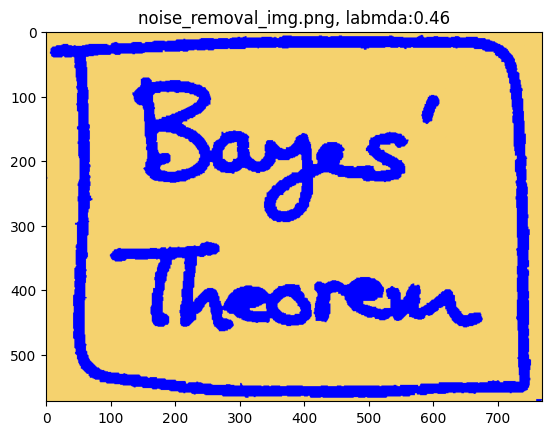

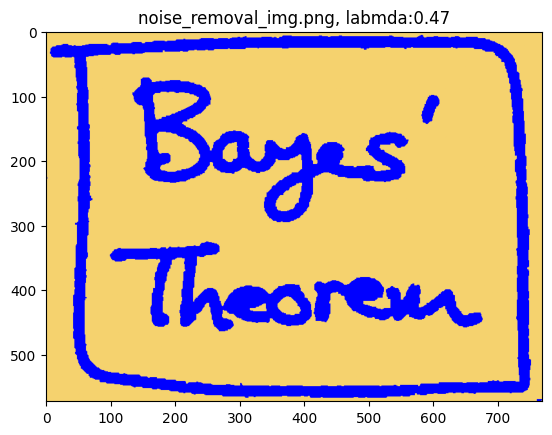

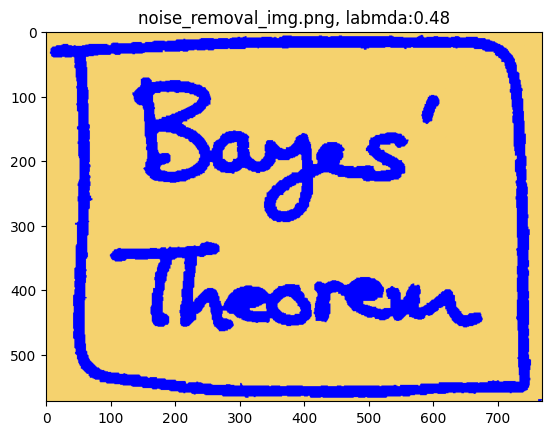

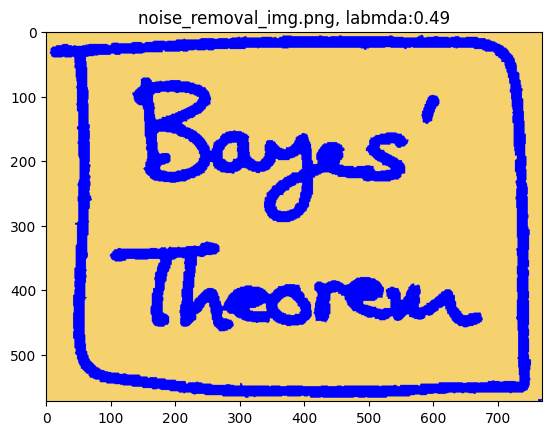

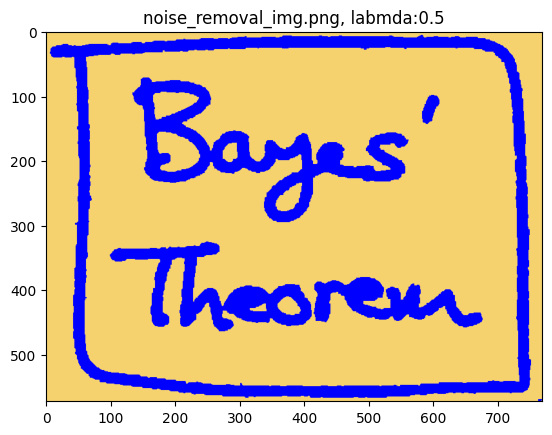

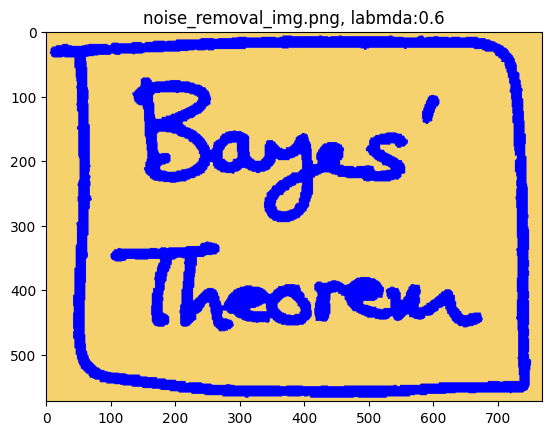

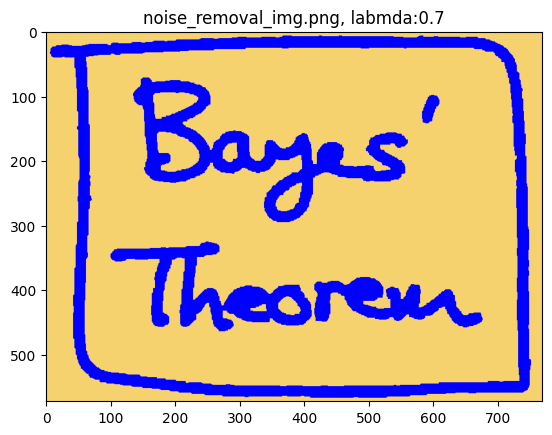

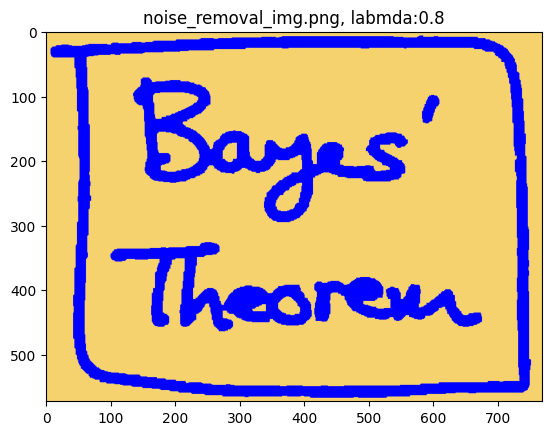

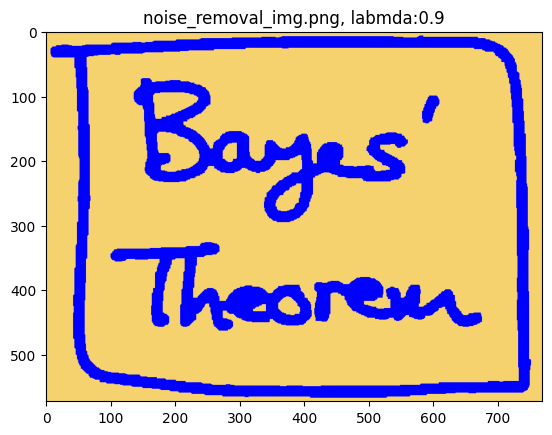

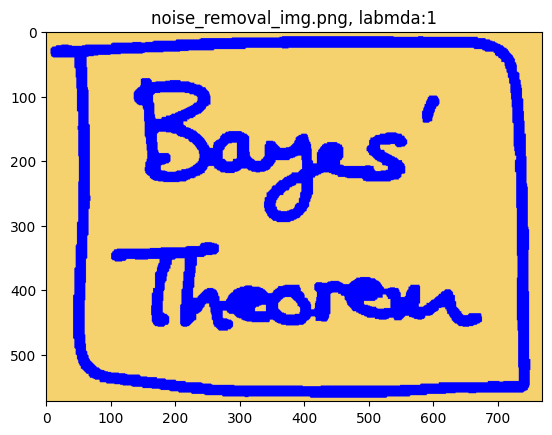

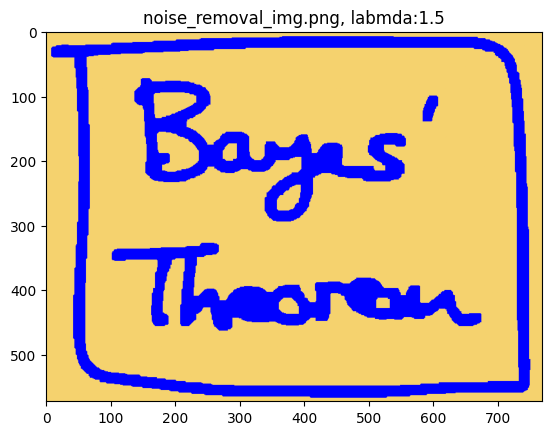

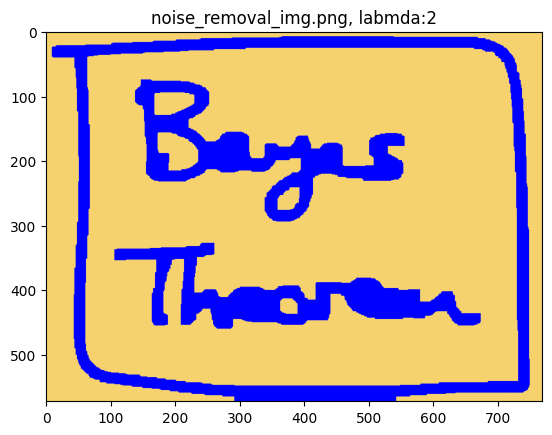

In [15]:
logger: logging.Logger = get_logger(__name__)
LAMBDAS = [0.2, 0.3, 0.4, 0.42, 0.45,0.46, 0.47, 0.48, 0.49,0.5, 0.6,0.7,0.8,0.9,1,1.5,2]
NUM_LABELS: int = 2 # the number of labels(freground: SINK_COLOR, background: SOURCE_COLOR)
SOURCE_COLOR: numpy.ndarray = numpy.array(object=[0,0,255])
SINK_COLOR: numpy.ndarray = numpy.array(object=[245,210,110])
for l in LAMBDAS:
    img:numpy.ndarray = cv2.imread('data/bayes_in.jpeg' , cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    gco = pygco.GCO()
    gco.create_general_graph(num_sites=height * width, num_labels=2, energy_is_float=True)
    unary_cost: numpy.ndarray = numpy.zeros(shape=(height* width, NUM_LABELS))

    for y in range(height - 1):
        for x in range(width - 1):
            node = y * width + x
            c: numpy.ndarray = img[y,x]
            # ds1 = compute_distance(c, SINK_COLOR)
            # ds2 = compute_distance(c, SOURCE_COLOR)
            unary_cost[node, 0] = compute_distance_normalize(c, SOURCE_COLOR)
            unary_cost[node, 1] = compute_distance_normalize(c, SINK_COLOR)
            # nx = x + 1
            next_node = node + 1
            gco.set_neighbor_pair(node, next_node, l)
            # ny = y + 1
            next_node = node + width
            gco.set_neighbor_pair(node, next_node, l)
    gco.set_data_cost(unary=unary_cost)
    pairwise_cost = (1 - numpy.eye(NUM_LABELS)) * l
    gco.set_smooth_cost(pairwise_cost)
    gco.expansion()
    labels:numpy.ndarray = gco.get_labels().reshape(height, width)
    for y in range(height):
        for x in range(width):
            id = y * height + x
            if labels[y,x] == 0:
                img[y, x] = SOURCE_COLOR
            elif labels[y,x] == 1:
                img[y, x] = SINK_COLOR
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f"data/noise_removal_img.png", img)
    img = matplotlib.image.imread("data/noise_removal_img.png")
    matplotlib.pyplot.title(f"noise_removal_img.png, labmda:{l}")
    matplotlib.pyplot.imshow(X=img)
    matplotlib.pyplot.show()